In [11]:
import pickle
%matplotlib inline
from pylab import *
from IPython.display import clear_output
#from cam import loadframe
from copy import deepcopy
from scipy.optimize import curve_fit, leastsq
from scipy.signal import fftconvolve
from numpy import fft
from scipy.ndimage import gaussian_filter
from scipy.ndimage import shift
from scipy.ndimage import *

gray()
def fig1(figsize=(8,8)):
    figure(figsize=figsize)
def fig2(figsize=(16,8)):
    figure(figsize=figsize)
def fig3(figsize=(15,8)):
    figure(figsize=figsize)

    
### library from smith 2019
import skimage.measure as skmeas
from skimage.morphology import medial_axis, skeletonize
from skimage.filters import sobel
import skimage.filters as skfilt
from skimage.measure import regionprops
import skimage.morphology as skmorph
from skimage.segmentation import watershed
import skimage.segmentation as skseg
import scipy.ndimage as ndi

from cellpose import models, io,utils

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=False, model_type='bact_omni')


<Figure size 432x288 with 0 Axes>

In [159]:
## import segmentation functions
import sys  
sys.path.insert(0, './mothermachine_funcs')

import bacteria_filters
import bacteria_measurement_funcs
import bacteria_segmentation
import bacteria_tracking_funcs
import bacteria_post_segmentation
import channel_detection_funcs

#import correct_shift_funcs


ModuleNotFoundError: No module named 'channel_detection_funcs'

In [179]:
from importlib import reload

reload(bacteria_filters)
reload(bacteria_measurement_funcs)
reload(bacteria_segmentation)
reload(bacteria_tracking_funcs)
reload(bacteria_post_segmentation)
#reload(channel_detection_funcs)
#reload(correct_shift_funcs)

<module 'bacteria_post_segmentation' from '/Users/nicola/Desktop/data_roma/Mothermachine/optogrowth/notebook/./mothermachine_funcs/bacteria_post_segmentation.py'>

In [14]:
def clean_cellpose(labeled_bacteria,outlines,
                    min_av_width=1,
                    maxsize=2000, #uint16((5*2)/(pix2mic**2))  ### max area
                    minsize=100): #uint16((0.5*0.1)/(pix2mic**2))    ### min area
    '''
    labeled_bacteria: result mask from cellpose
    outlines: coordinated defining the channels [x1,x2,y1,y2]
    '''
    newbac = np.zeros(labeled_bacteria.shape, dtype=labeled_bacteria.dtype)
    [x1,x2,y1,y2]=outlines
    
    stats = dict(
        num_rejected_av_width=0,
        num_rejected_area=0,
        num_rejected_channel=0,
    )

    dist = ndi.distance_transform_edt(labeled_bacteria > 0)
    label = 0
    for region in regionprops(labeled_bacteria):
        masked_bac = labeled_bacteria == region.label
        skel = skeletonize(masked_bac)
        av_width_skel = np.mean(dist[skel])
        (y,x) = region.centroid

        if av_width_skel < min_av_width:
            stats["num_rejected_av_width"] += 1
            continue

        if (x<x1) or (x>x2) or (y<y1) or (y>y2):
            stats["num_rejected_channel"] += 1
            continue

        if maxsize > region.area > minsize:
            label += 1
            newbac[labeled_bacteria == region.label] = label

        if  region.area > maxsize:
            stats["num_rejected_area"] += 1
          
    return newbac,stats

In [15]:
import pickle
dt=3
with open('bacteria_shift_indx.pickle','rb') as f:
    [dr,s,alpha,N_channels,x1_ind,x2_ind,y1,y2]= pickle.load(f)
dr=load('dr_shift.npy')

import pickle
with open('bacteria_frames.pickle','rb') as f:
    [bacteria_frames]=pickle.load(f)
    
# adjust shift to be coherent with time
dr_ad=zeros((shape(dr)[0]*dt,shape(dr)[1]))
dr_ad[::3,:]=dr;dr_ad[1::3,:]=dr;dr_ad[2::3,:]=dr


'           \nfigure(figsize=(25,20))\nfor ch_n,frame in enumerate(frames[:-1]):\n    subplot(1,N_channels,ch_n+1)\n    img=gaussian_filter(frame,3)\n    masks, flows, styles, diams = model.eval(img, diameter=40, channels=chan,flow_threshold=0.7)\n    outlines=[x1_ch,x2_ch,y1_ch,y2_ch]\n    newbac,stats=clean_cellpose(masks,outlines )\n    imshow(newbac)\n'

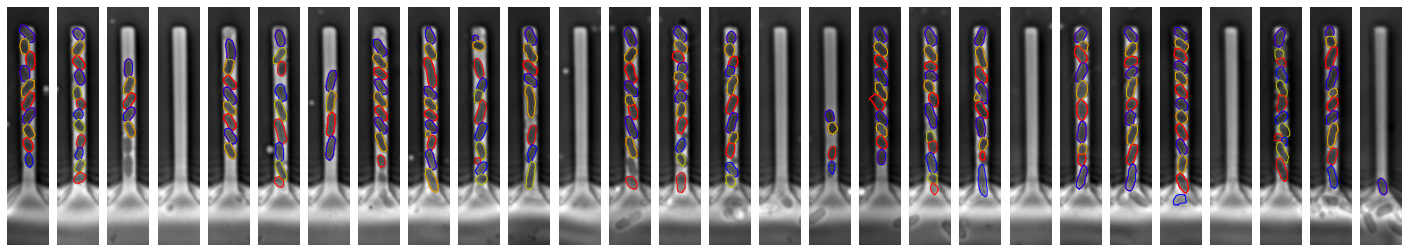

In [17]:
with open('bacteria_test.pickle','rb') as f:
    [frames]=pickle.load(f)
colors=['r','b','y']
chan=[[0,0]]

from pylab import *
figure(figsize=(25,20))
for ch_n,frame in enumerate(frames):
    subplot(1,N_channels,ch_n+1)
    img=gaussian_filter(frame,1)
    masks, flows, styles, diams = model.eval(frame, diameter=50, channels=chan,flow_threshold=0.7)
    outlines=[x1_ch,x2_ch,y1_ch,y2_ch]
    newbac,stats=clean_cellpose(masks,outlines,minsize=50 )
    imshow(frame)
    axis('off')
    for jj,u in enumerate(unique(newbac)):
        bb = skmeas.find_contours(newbac==u, 0.5)
    #    for jj,b in enumerate(bb):
        if bool(bb):
            plot(bb[0][:, 1], bb[0][:, 0], linewidth=1,c=colors[jj%3])
savefig('cellpose.png')
'''           
figure(figsize=(25,20))
for ch_n,frame in enumerate(frames[:-1]):
    subplot(1,N_channels,ch_n+1)
    img=gaussian_filter(frame,3)
    masks, flows, styles, diams = model.eval(img, diameter=40, channels=chan,flow_threshold=0.7)
    outlines=[x1_ch,x2_ch,y1_ch,y2_ch]
    newbac,stats=clean_cellpose(masks,outlines )
    imshow(newbac)
'''

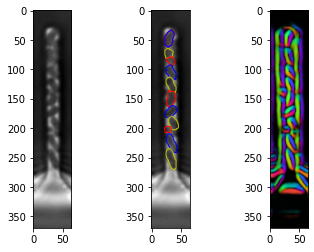

In [18]:
ch_n=25
#img=gaussian_filter(,2)
masks, flows, styles, diams = model.eval(frames[ch_n], diameter=50, channels=chan,flow_threshold=0.7)
outlines=[x1_ch,x2_ch,y1_ch,y2_ch]
newbac,stats=clean_cellpose(masks,outlines )
subplot(131)
imshow(frames[ch_n])
subplot(132)
imshow(frames[ch_n])
for jj,u in enumerate(unique(newbac)):
    bb = skmeas.find_contours(newbac==u, 0.5)
#    for jj,b in enumerate(bb):
    if bool(bb):
        plot(bb[0][:, 1], bb[0][:, 0], linewidth=1,c=colors[jj%3])

subplot(133)
imshow(flows[0])

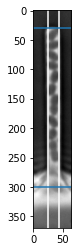

In [164]:
i=300
ch_selected =4
img = bacteria_frames[int(i/dt)][ch_selected]
imshow(img)


x1_ch=25
x2_ch=43
y1_ch=30
y2_ch=300
axvline(x1_ch,color='w')
axvline(x2_ch,color='w')
axhline(y1_ch)
axhline(y2_ch)

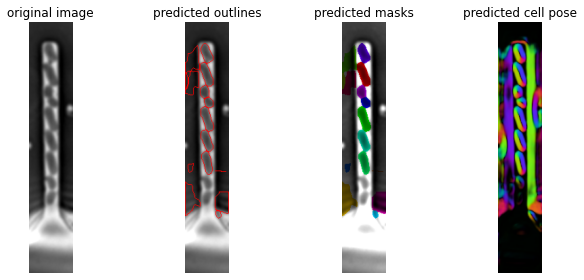

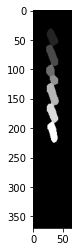

In [20]:
i=300
ch_selected =0
img = bacteria_frames[int(i/dt)][ch_selected]

chan=[0,0]
img=gaussian_filter(img,1)
masks, flows, styles, diams = model.eval(img, diameter=40, channels=chan,flow_threshold=0.7)

from cellpose import plot

fig = plt.figure(figsize=(10,4))
plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
plt.tight_layout()
plt.show()

outlines=[x1_ch,x2_ch,y1_ch,y2_ch]
newbac,stats=clean_cellpose(masks,outlines )
imshow(newbac)

#  SEGMENTATION WITH cellpose


In [182]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output
    
N_channels = shape(x1_ind)[0]  # total number of channels 
channel_selected = array([0,1,2,3,4,6,7,8,10,11,13,14,15,16,17,18,21,22,23,24,25,26])#arange(N_channels)
dt_acq=3
n_frames_max=len(dr)*dt_acq
max_important_bacteria=5
out_label=2000

t_skip=3

diameter = 45 # for cell pose
outlines=[x1_ch,x2_ch,y1_ch,y2_ch] # channel walls positions
sigma=1
chan=[[0,0]]

tmin=0 # minutes
#dt_acq=3 # minutes
frames_selected = arange(tmin,n_frames_max,t_skip*dt_acq);
n_frames_selected = frames_selected.shape[0];
y_subtraction =0  # to remove cells outside mother machine

allbacteria_tot = [] # here will be loaded segmented images 
allbacteria2_tot = []
imp_bac_tot =[]

flags_tot=[]
checks_tot=[]
lineage_tot=[]
opts_tot=[]

#aw0=5

for ch_n, ch_selected in enumerate(channel_selected):
    print('channel number{}'.format(ch_selected))    
    allbacteria = [] # here will be loaded segmented images 
    allbacteria2 = []
    imp_bac =[]
    flags=[]
    checks=[]
    opts=[]
    
    temp_bacteria_lineage = {}
    cc=0
    empty_well=False
    
    for i in frames_selected:  # cycle on each frame
        clear_output(wait=True)
        print('channel number{}'.format(ch_selected)) 
        print(i,flush=True)
#        print(i)

        segs={}
        segs2={}
        unlabelled_bacteria=[]
        bacteria=[]    
        channel_images_raw = {}

        # load the channel image
        if 'bacteria_frames' in locals():                
            channel_images_raw[0]= bacteria_frames[int(i/(dt_acq*t_skip))][ch_selected]
        else:                
            DR=[dr[int(i/dt_acq),0],dr[int(i/dt_acq),1]]
            img= getdata(i,dr=DR,s=s,angle=alpha)
            channel_images_raw[0] =  img[y1:y2,x1_ind[ch_selected]:x2_ind[ch_selected]]

#        channel_images= bacteria_filters.remove_background(channel_images_raw, radius=20, light_background=True)

#        segs = bacteria_filters.channel_gaussian_laplace(channel_images) # scale transformation using lapalacian function in bacteria_filters.py

        flag=False
        flag2=True

#        aw=aw0
        if cc>0:
            uu=unique(allbacteria2[cc-1][0])
            important_bac= min(max_important_bacteria,len(uu[uu!=out_label])-1) # all bacteria are important,
                               
        else:
            important_bac= max_important_bacteria
        bacteria={}
        img= gaussian_filter(channel_images_raw[0],sigma)
#        masks, flows, styles, diams = model.eval(-channel_images_raw[0], diameter=diameter, channels=[0,0])
        masks, flows, styles, diams = model.eval(img, diameter=diameter, channels=chan,flow_threshold=0.6)
        bacteria[0],stats=clean_cellpose(masks,outlines, maxsize=2000, minsize=100)


        while not flag:
#            bacteria,thresh_array = bacteria_segmentation.bacteria_watershed(segs,maxsize=10000,minsize=100,
#                                                              absolwidth=aw)

#            unlabelled_bacteria = bacteria_post_segmentation.split_bacteria_in_all_wells(segs2,channel_images,min_skel_length=20) # funcs in bacteria_post_segmentation.py
#            bacteria = bacteria_post_segmentation.relabel_bacteria(unlabelled_bacteria) # funcs in bacteria_post_segmentation.py                
            if bacteria[0].max()==0:  ### bacteria channel is empty

                print('bacteria channel is empty')
                temp_allbacteria2=deepcopy(bacteria)
                temp_check_probs=[]
                flag=True
                empty_well=True

            else:
                
                if cc==0 or empty_well==True :  # initialase the bacteria_lineage variable

#                        if bool(temp_bacteria_lineage):
#                            last_label= max(temp_bacteria_lineage.keys()) 
#                        else:
#                            last_label = 0
                    temp_allbacteria2, temp_bacteria_lineage = bacteria_tracking_funcs.label_all_new(
                        bacteria[0],temp_bacteria_lineage,important_bac=max_important_bacteria,out_label=out_label)

                    print(cc)
                    flag=True
                    temp_check_probs=[]
                    temp_best_options=[]
                    empty_well= False


                if cc>0:
                    bacteria_lineage_old= deepcopy(bacteria_lineage)
                # tracking function based on a probabilistic approach   functions in # funcs in bacteria_tracking.py
                    temp_allbacteria2, temp_bacteria_lineage,temp_check_probs,temp_best_options = bacteria_tracking_funcs.bacteria_tracking(
                                allbacteria2[cc-1],
                                bacteria,
                                bacteria_lineage_old,
                                prob_div=0.2,   # probability of a division to occur 
                                prob_death=1e-12,  # probability of cell lysis (note that for the last bacteria in a channel this is set to higher value)
                                prob_no_change=0.8, # prob that nothing happen (i know the sum is not 1 ... still working on)
                                av_bac_length=60.,   # lenght of an average bacteria  
                                important_bac=important_bac,
                                max_important_bac=max_important_bacteria,
                                out_label=out_label
                                )

                    flag= bacteria_tracking_funcs.find_problems(temp_check_probs,
                                                                important_bac=important_bac)
                    print(flag)
                    if flag==False:
                            if important_bac<2:  # with 2 basically you are accounting only for the mother
                                print('giving up and renaming all new bacteria')
                                #bacteria_lineage_old= deepcopy(bacteria_lineage)
                                temp_allbacteria2, temp_bacteria_lineage = bacteria_tracking_funcs.label_all_new(bacteria[0],
                                                                                                                 bacteria_lineage_old,
                                                                                                                 important_bac=max_important_bacteria,
                                                                                                                 out_label=out_label)
                                flag=True
                                flag2=False
                            else:
                                important_bac-=1
                                print('reducing important bacteria to {}'.format(important_bac)) 

        allbacteria2.append(temp_allbacteria2)
        allbacteria.append(bacteria)
        bacteria_lineage=deepcopy(temp_bacteria_lineage)
        flags+=[flag2]
        checks+=[temp_check_probs]
        imp_bac+=[important_bac]
        opts+=[temp_best_options]

        cc+=1 # aumenta il counter solo dopo essere uscito dal while
#    allbacteria_tot.append(allbacteria) # here will be loaded segmented images 
    allbacteria2_tot.append(allbacteria2)
    allbacteria_tot.append(allbacteria)
    flags_tot.append(flags)
    checks_tot.append(checks)
    opts_tot.append(opts)
    lineage_tot.append(bacteria_lineage)
    imp_bac_tot+=[imp_bac]

    #save all results
    with open('allbacteria2_tot_all.pickle','wb') as f:
        pickle.dump([allbacteria2_tot,lineage_tot,channel_selected,dt_acq,t_skip], f)

channel number0
3933
291
[False]
reducing important bacteria to 2
291
[False]
reducing important bacteria to 1
291
[False]
giving up and renaming all new bacteria


In [172]:
i= 1
checks[i][0]
#imp_bac[i]
opts[i]
#flags[i]

{0: (1, 2, 3, 4, 5, 5)}

In [153]:
i= int(1251/9)
i

139

In [158]:
if array([False,True])==False:
    print('ciao')


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# plot tracking result for the first channel analysed  
note that new born bacteria have a label (intensity) that is the lowest number not taken by other bacteria, so if you analysed multiple channel, this image will new born all as yellow. To have a decent image run segmentation only on one channel. (for example only channel 0)  


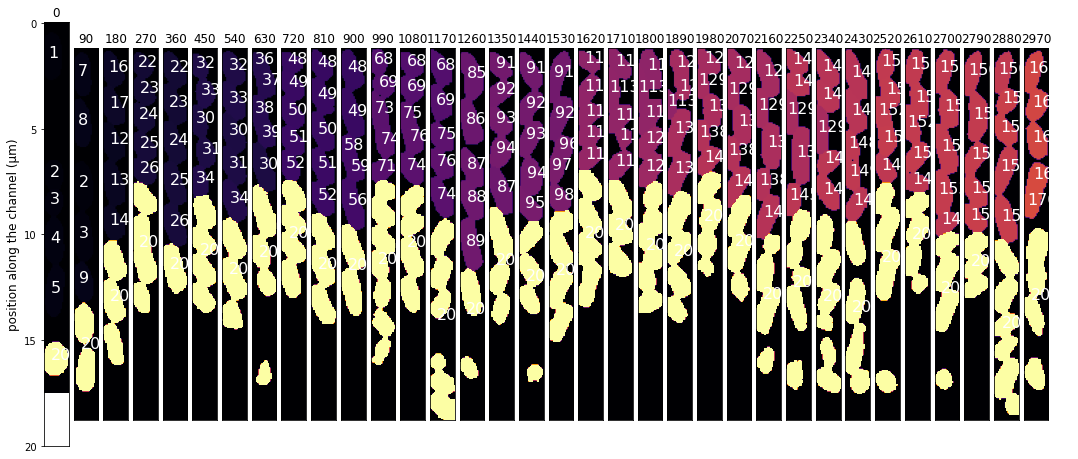

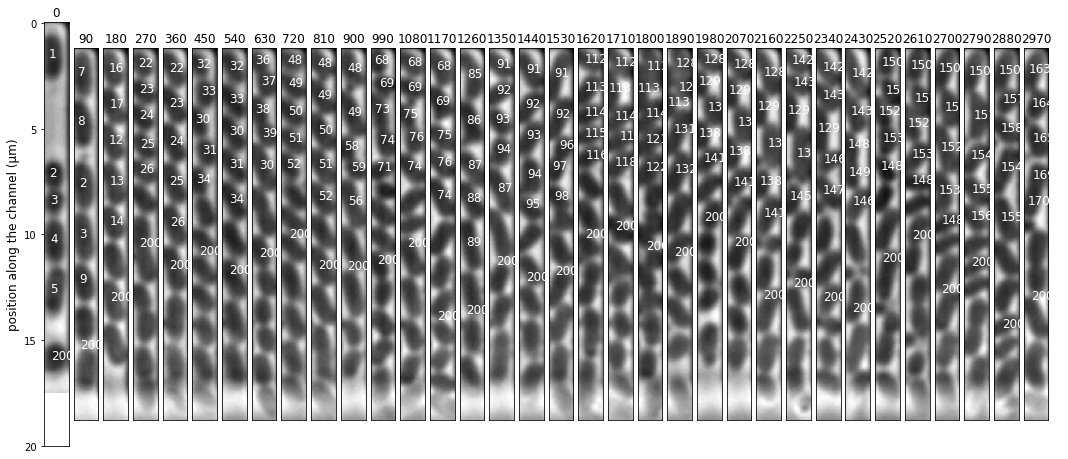

In [185]:
with open('allbacteria2_tot_all.pickle','rb') as f:
    [allbacteria2_tot,lineage_tot,channel_selected,dt_acq,t_skip]= pickle.load(f)
tmin=int(0/(dt_acq*t_skip))
vmax= 300
k=0#n_frames_selected  
maxn=int(3000/(dt_acq*t_skip))#30/3#shape(allbacteria2)[0]
skip_n=10
n=arange(0,maxn,skip_n)
cc=1
splot=[slice(outlines[2],outlines[3]),slice(outlines[0],outlines[1])]


figure(figsize=(18,10))
for nn in n:

        
    subplot(1,len(n),cc);
    cc+=1
    im=allbacteria2_tot[k][nn+tmin][0]
    im=im[splot]
    
    imshow(where(im>0,im+5,0),cmap='inferno',vmin=0,vmax=vmax);
    for region in regionprops(im):
        pos_text= region.centroid
        text(pos_text[1]-3,pos_text[0],region.label,c='w',fontsize=16)

    title((nn+tmin)*dt_acq*t_skip)
    xticks([])
    yticks([])
    if nn==0:
        ax=gca()
        lx=arange(0,25,5)
        xx=lx*(100/6.5)
        ax.set_yticks(xx)
        ax.set_yticklabels(lx)
        ylabel(u'position along the channel (\u00b5m)',fontsize=12)
savefig('figures/figure-segmentation.png')

cc=1
figure(figsize=(18,10))
for nn in n:
        
    subplot(1,len(n),cc);
    cc+=1
    im_raw=bacteria_frames[nn+tmin][channel_selected[k]]
    im_raw=im_raw[splot]
    im=allbacteria2_tot[k][nn+tmin][0]
    im=im[splot]
    imshow(im_raw);
    for region in regionprops(im):
        pos_text= region.centroid
        text(pos_text[1]-3,pos_text[0],region.label,c='w',fontsize=12)

    title((nn+tmin)*dt_acq*t_skip)
    xticks([])
    yticks([])
    if nn==0:
        ax=gca()
        lx=arange(0,25,5)
        xx=lx*(100/6.5)
        ax.set_yticks(xx)
        ax.set_yticklabels(lx)
        ylabel(u'position along the channel (\u00b5m)',fontsize=12)
savefig('figures/figure-segmentation_raw.png')



In [ ]:
bacteria_tracking_funcs.find_max_keys(bacteria_lineage,out_label=2004)

In [186]:
bacteria_lineage

{1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 2000: '2000',
 6: '5_1',
 7: '1_1',
 8: '1_2',
 9: '4_1',
 10: '3_1',
 11: '3_2',
 12: '1_2_1',
 13: '1_2_2',
 14: '2_1',
 15: '2_2',
 16: '1_1_1',
 17: '1_1_2',
 18: '1_2_2_1',
 19: '1_2_2_2',
 20: '20',
 21: '21',
 22: '1_1_1_1',
 23: '1_1_1_2',
 24: '1_1_2_1',
 25: '1_1_2_2',
 26: '1_2_1_1',
 27: '1_2_1_1_1',
 28: '1_1_2_2_1',
 29: '1_1_2_2_2',
 30: '1_1_1_2_1',
 31: '1_1_1_2_2',
 32: '1_1_1_1_1',
 33: '1_1_1_1_2',
 34: '1_1_2_1_1',
 35: '1_1_2_1_1_1',
 36: '1_1_1_1_1_1',
 37: '1_1_1_1_1_2',
 38: '1_1_1_1_2_1',
 39: '1_1_1_1_2_2',
 40: '40',
 41: '41',
 42: '40_1',
 43: '40_2',
 44: '44',
 45: '45',
 46: '46',
 47: '47',
 48: '48',
 49: '49',
 50: '50',
 51: '51',
 52: '52',
 53: '50_1',
 54: '50_2',
 55: '55',
 56: '56',
 57: '57',
 58: '55_1',
 59: '55_2',
 60: '56_1',
 61: '49_1',
 62: '49_2',
 63: '48_1',
 64: '48_2',
 65: '65',
 66: '66',
 67: '67',
 68: '68',
 69: '69',
 70: '70',
 71: '71',
 72: '72',
 73: '70_1',
 74: '70_2',
 75

# gather results

In [187]:
# make bacteria_lineage unique
smax=0
mamma_labels=[]
channel_selected=arange(1)
for cc,ch_n in enumerate(channel_selected):
    if cc==0:
        bacteria_lineage_tot=deepcopy(lineage_tot[0])
        bacteria_lineage_tot.update({bacdic: 'ch%d__'%ch_n+str(bac_label)
                            for bacdic, bac_label in (lineage_tot[0]).items()})
    else:
        
        #smax = smax+max(lineage_tot[cc-1], key=int)
        smax = max(bacteria_lineage_tot, key=int)
        if bool(lineage_tot[cc]):
            bacteria_lineage_tot.update({bacdic+smax: 'ch%d__'%ch_n+str(bac_label)
                                    for bacdic, bac_label in (lineage_tot[cc]).items()})
        
    mamma_labels.append(smax)
    

# here the class measurements contains all the information about single bacteria. 

In [188]:

# information on the i(>0 they start from 1) bacteria can be obtained for example as: 
# Area                          >> measurement.bacteria[i].bf_measurements['Area'] 
# label (discendence)           >> measurement.bacteria[i].bacteria_label
fluo_flag=None

measurements = bacteria_measurement_funcs.BacteriaData()
fluorescence_backgrounds = {}
y_subtraction =0
channel_selected=arange(1)
for ch_n in arange(len(channel_selected)):#(len(channel_selected)):
    for tpoint in arange(shape(allbacteria2_tot[ch_n])[0]):        
        
        clear_output(wait=True)
        print('channel number{}'.format(channel_selected[ch_n])) 
        print(tpoint,flush=True)

                
        bacteriaim= deepcopy(allbacteria2_tot[ch_n][tpoint][0]).astype(uint16)
        bacteriaim[bacteriaim>0]+=mamma_labels[ch_n]
        in_list=[]
        centroid_pos=[]
        # remove the not important bacteria:
        for region in regionprops(bacteriaim):
                # list the bacteria labels from the current frame
                in_list.append(region.label)
                centroid_pos.append(region.centroid[0])

        ind_sort_y = argsort(centroid_pos)  # nicola: important to sort the list
        in_list = array(in_list)
        in_list= in_list[ind_sort_y]
        
#### maybe i need to create a list taking in consideration the important bacteria

#        for j, label in enumerate(in_list):
#            if j>= important_bac-1:  # still need to think about this
#                bacteriaim[bacteriaim==label]= bacteriaim.min()

        # load data into the variable        
        for region in regionprops(bacteriaim):
            
            if fluo_flag is not None:
                # load data from Fluorescence 
                realt= tmin+(tpoint)*t_skip*dt_acq
                DR=[dr_ad[realt,0],dr_ad[realt,1]]
                bacteriaim = allbacteria2_tot[ch_n][tpoint][0]

                fldata= getdataFL(realt,angle=alpha,s=s,folder='../dataFL',dr=DR )
    #            bfdata= getdata(realt,angle=alpha,s=s,folder='../dataBF',dr=DR )


                fl_shift=[10,-8]
                fl_ch= fldata[y1+fl_shift[0]: y2+fl_shift[0] , int(x1_ind[ch_n]+fl_shift[1]) : int(x2_ind[ch_n]+fl_shift[1]) ]
#                bf_ch= bfdata[y1:y2,x1_ind[ch_n]:x2_ind[ch_n]]

                fluo=mean(fl_ch[bacteriaim==region.label])
            else:
                fluo=None
            

            measurements.add_bac_data(
                region.label, bacteria_lineage_tot, 
                region, tpoint*t_skip*dt_acq,well_label=ch_n,fluo=fluo)
            
#            measurements.bacteria[region.label]['Fluo']=fluo



measurements.compile_results(max_tpoint=n_frames_selected)

#with open('mesaurement.pickle','wb') as f:
#    pickle.dump([measurement], f)

channel number0
437


In [189]:
with open('mesaurements_all.pickle','wb') as f:
    pickle.dump([measurements], f)

In [190]:
with open('mesaurements_all.pickle','rb') as f:
    [mm]=pickle.load(f)

# ESTIMATE GROWTH RATE

selected bacteria
number of bacteria in the statistics N= 42
number of not nans N= 42


IndexError: list index out of range

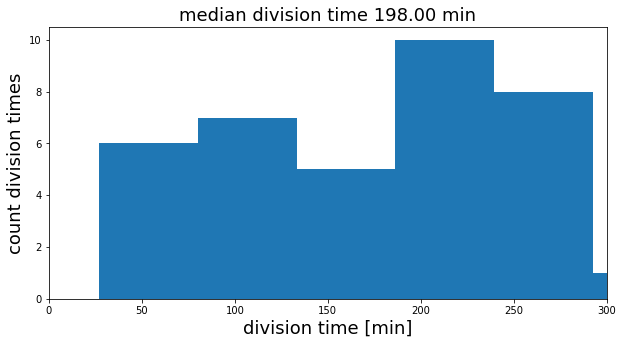

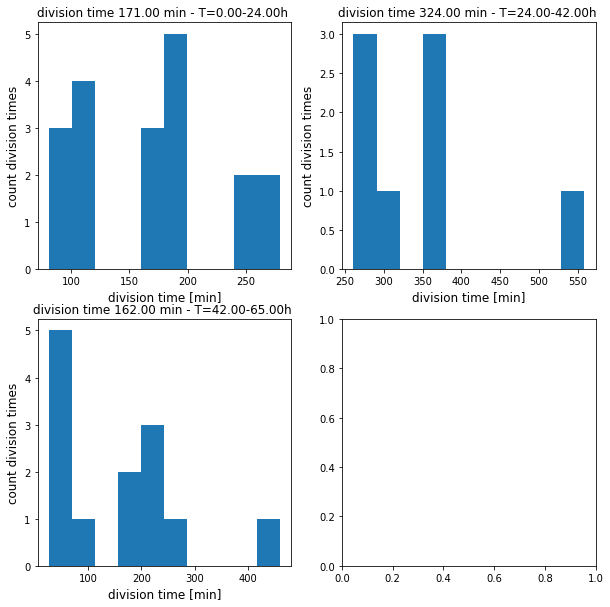

In [191]:
t_skip=3
pix2mic=6.5/100.
min_tracking_time=2
#t_skip=3
dt_acq=3
div_time=[];length_bd=[];length_div=[];times=[];
print('selected bacteria')
cc=0

max_time=0
for numbac, (bac) in enumerate(mm.bacteria.values()):
    max_time=max(bac.timepoints[-1],max_time)

flag=False
for numbac, (bac) in enumerate(mm.bacteria.values()):
        if bac.bacteria_label.find('2000')>4:
            flag=False
        else:            
            ### checking staff
            length= bac.bf_measurements['Length']
            mother_name=bac.bacteria_label[:-2]
            son_name= bac.bacteria_label+'_1'
            gr= mean(diff(length))*(pix2mic)/3
            if (len(length)>min_tracking_time):# & (gr>0.01):
                for numbac_mother, (bac_mother) in enumerate(mm.bacteria.values()):
                    if bac_mother.bacteria_label == mother_name:
                            for numbac_son, (bac_son) in enumerate(mm.bacteria.values()):
                                if (bac_son.bacteria_label == son_name):
                                    flag=True
                                    #print(bac.bacteria_label)
                                    #print(bac.timepoints[0])
        if flag:                            
            div_time.append(len(length))
            length_bd.append(length[0])
            length_div.append(length[-1])
            times += [bac.timepoints[0]]
            cc+=1
            flag=False
                                #print(bac.bacteria_label)

times= array(times)/60. ### time in hours
div_time = array(div_time)*(t_skip*dt_acq) ## 3 minutes each image
length_bd = array(length_bd)*(pix2mic)
length_div = array(length_div)*(pix2mic)

figure(figsize=(10,5))
hist(div_time); xlabel('division time [min]',fontsize=18); 
xlim([0,300])
ylabel('count division times',fontsize=18); 
title('median division time %0.2f min'%median(div_time),fontsize=18)
savefig('figures/division_time.png')

print('number of bacteria in the statistics N= {}'.format(cc))
print('number of not nans N= {}'.format(len(div_time[~isnan(div_time)] )))

figure(figsize=(10,10))
time_limits= [0,24,42,65]

for jj in arange(4):
    subplot(2,2,jj+1)

    cond=(times>time_limits[jj])*(times<time_limits[jj+1])
    

    hist(div_time[cond]); xlabel('division time [min]',fontsize=12); 
#    xlim([0,300])
    ylabel('count division times',fontsize=12); 
    title('division time {:0.2f} min - T={:0.2f}-{:0.2f}h '.format(median(div_time[cond]),time_limits[jj],time_limits[jj+1]),fontsize=12)
tight_layout()
savefig('figures/division_time_multipletimes.png')


In [142]:
1426/60

23.766666666666666

In [ ]:
2529/60

In [143]:
3900/60

65.0

# NOT DIVIDING CELLS

In [ ]:
pix2mic=6.5/100.
min_tracking_time=4
max_tracking_time=8
t_skip=3
dt_acq=3
div_time=[];length_bd=[];length_div=[];times0=[];times1=[];gr=[]

cc=0

max_time=0
for numbac, (bac) in enumerate(mm.bacteria.values()):
    max_time=max(bac.timepoints[-1],max_time)

flag_mother=False;flag_end=False;flag_gr=False;flag_longtime=False;flag_son=False

for numbac, (bac) in enumerate(mm.bacteria.values()):
        flag_mother=False;flag_end=False;flag_gr=False;flag_longtime=False
        ### checking staff
        if bac.bacteria_label.find('_')>=0:# we exclude the ones which no have a mother in the mothermachine
            
            # putting things into variables
            length= bac.bf_measurements['Length']
            mother_name=bac.bacteria_label[:-2]
            son_name= bac.bacteria_label+'_1'
            growth_rate= nanmean(diff(bac.bf_measurements['Area']))*(pix2mic)/(dt_acq*t_skip/60)
            
            
            if (len(length)>min_tracking_time):
                
                ### check if there is mother
                for numbac_mother, (bac_mother) in enumerate(mm.bacteria.values()):
                    if bac_mother.bacteria_label == mother_name:
                        flag_mother=True
                
                if bac.timepoints[-1]==max_time:
                        flag_end=True
                            
                ### check if it has a long life
                if len(bac.timepoints)> max_tracking_time:
                            flag_longtime=True
                        
                ### check if it has a son
                for numbac_son, (bac_son) in enumerate(mm.bacteria.values()):
                    if (bac_son.bacteria_label == son_name):
                        if len(bac.timepoints)> max_tracking_time:
                            flag_son=True
                            
                ### check growth rate
                if growth_rate < 1: # elongation of 1 um/h
                    flag_gr=True
                    
                            
        cond= flag_mother and flag_gr and (flag_longtime or flag_end)                    
        if cond:     

            div_time.append(len(length)*(t_skip*dt_acq))
            times0 += [bac.timepoints[0]]
            times1 += [bac.timepoints[-1]]
            gr += [growth_rate]
            cc +=1


times0= array(times0)/60. ### time in hours
times1= array(times1)/60.
div_time = array(div_time)/60 ## 3 minutes each image
gr=array(gr)

figure(figsize=(9,3))
subplot(122)
hist(div_time); xlabel('division time [h]',fontsize=12); 
xlim([0,10])
ylabel('count division times',fontsize=12); 
title('super-slow growing median division time %0.2f h'%median(div_time),fontsize=12)

print('number of bacteria in the statistics N= {}'.format(cc))
print('number of not nans N= {}'.format(len(div_time[~isnan(div_time)] )))

subplot(121)
time_limits= [0,4,8,12,16]
nd=[]
for jj in arange(4):

    cond1=(times0<=time_limits[jj])*(times1>=time_limits[jj])
    cond2= (times1>=time_limits[jj+1])*(times0<=time_limits[jj+1])
    cond3 = (times0>=time_limits[jj])*(times1<=time_limits[jj+1])

    nd+=[len(div_time[logical_or(cond1,cond2,cond3)])]; 
    
plot(time_limits[1:],nd,'o')
xlabel('time-limits[h]',fontsize=12); 
ylabel('count of not dividing cells',fontsize=12); 
title('super-slow growning cells over time',fontsize=12)
tight_layout()
savefig('figures/division_not dividing.png')

#subplot(133)
figure()
hist(gr); xlabel('growth rate [$\mu$m/h]',fontsize=12); 
xlim([-2,2])
ylabel('N cells',fontsize=12); 
tight_layout()
title('median growth rate of slowly growning%0.2f [$\mu$m/h]'%median(gr),fontsize=12)

In [ ]:
gr

In [ ]:
# look for my history order

pix2mic=6.5/100.
branch='ch3__1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1';

fluo_flag=None

area=[];length=[];times=[];fluo=[];
print('selected bacteria')
for numbac, (bac) in enumerate(mm.bacteria.values()):

        #print numbac
#        if numbac == 0:
        if (branch).find(bac.bacteria_label)>=0:#str(label_mothers[k]):
            print(bac.bacteria_label)
            area= area+ bac.bf_measurements['Area']
            length= length + bac.bf_measurements['Length']
            times = times+ bac.timepoints
            if fluo_flag is not None:
                fluo = fluo+ bac.fluorescence['Fluo']
            
            
            
            
            
area=array(area)*(pix2mic**2)
length =array(length)*pix2mic
times=array(times) # images every 3minutes
growth_rate = diff(length); growth_rate[growth_rate<0] = nan
figure(figsize=(15,7))
#subplot(311);

plot(times/60,length,'-o'); xlabel('time [hours]',fontsize=18); ylabel('Length [$\mu$m]',fontsize=18)


#subplot(312);plot(times,area,'o');xlabel('time [min]',fontsize=18); ylabel('Area [$\mu$m$^{2}$]',fontsize=18);
#subplot(313);plot(times[1:],growth_rate,'o');xlabel('time [min]',fontsize=18); ylabel('elongation [1/min]',fontsize=18);
savefig('figures/story of a mother 2.png')

if fluo_flag is not None:
    figure()
    plot(times,fluo,'-o'); xlabel('time [min]',fontsize=18); ylabel('Length [$\mu$m]',fontsize=18)
    savefig('figures/fluo.png')